## Жерноклеев Дмитрий 
### Домашнее задание 3. ML часть

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set(style="darkgrid")

### Подгрузим сгенерированную нами выборку

In [2]:
df = pd.read_csv('def_train.csv')
df

,u,u_e,mu,p_e,delta,y
0,0.4,0.05,0.1,0.05,0.5,0.042133
1,0.4,0.05,0.1,0.10,0.2,0.151265
2,0.4,0.05,0.1,0.10,0.4,0.137932
3,0.4,0.05,0.1,0.10,0.5,0.054475
4,0.4,0.05,0.1,0.20,0.0,0.312031
...,...,...,...,...,...,...
824,1.4,0.20,0.5,0.20,0.5,0.709102
825,1.4,0.20,0.5,0.30,0.0,0.222245
826,1.4,0.20,0.5,0.30,0.2,0.500102
827,1.4,0.20,0.5,0.30,0.4,0.090000


In [3]:
display(df.dtypes)
df.isna().sum()

u        float64
u_e      float64
mu       float64
p_e      float64
delta    float64
y        float64
dtype: object

u        0
u_e      0
mu       0
p_e      0
delta    0
y        0
dtype: int64

### Разобьем на обучающую и тестовую части

In [4]:
y = df['y']
X = df.drop(columns=['y']).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [5]:
y_train

39     0.077806
195    0.231602
167    0.162383
451    0.183673
191    0.191389
         ...   
369    0.796593
320    0.177602
527    0.509453
125    0.128827
265    0.511250
Name: y, Length: 663, dtype: float64

### Отскейлим данные и обучим обычную Ridge регрессию

In [6]:
numeric_features = list(X_train.columns)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Train RMSE = %.8f" % mean_squared_error(y_train, model.predict(X_train), squared=False))
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Train RMSE = 0.25764492
Test RMSE = 0.26284403
Test R^2 = 0.19929146


#### RMSE получились большими, учитывая, что мы предсказываем y, а  $𝑅^2$  очень маленький, но пусть это будет бейслайн моделью

### Попробуем выделить валидационную часть и по поискать более оптимальные значения коэффициента регуляризации, возможно, это поможет снизить RMSE

In [7]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

Best alpha = 0.00000100


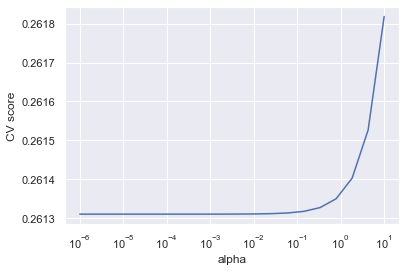

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

split_index = [-1 if x in X_train_new.index else 0 for x in X_train.index]
pds = PredefinedSplit(test_fold=split_index)

alphas = np.logspace(-6, 1, 20)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}], scoring="neg_root_mean_squared_error", cv=pds, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.8f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.show()

In [10]:
pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Ridge(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Test RMSE = 0.26285843
Test R^2 = 0.19920374


#### Качество не улучшилось. Попробуем проделать то же с Lasso-регрессией

Best alpha = 0.00000100


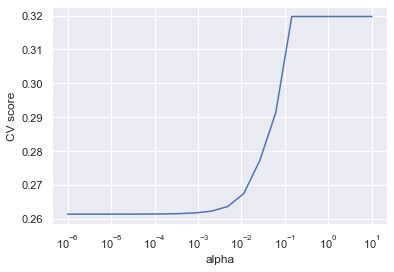

In [18]:
from sklearn.linear_model import Lasso
lasso_pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Lasso())
])

searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}], scoring="neg_root_mean_squared_error", cv=pds, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha1 = searcher.best_params_["regression__alpha"]
print("Best alpha = %.8f" % best_alpha1)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.show()

In [19]:
pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Lasso(best_alpha1))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.26285813


#### Снова нет улучшений

### Попробуем теперь обучить RandomForest

In [12]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500, max_features=int(X_train.shape[1] / 3))
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Test RMSE = 0.21665576
Test R^2 = 0.45597522


#### RMSE снизился на 0,05 (т.е. уменьшился почти на 20% по сравнению с бейслайном). $R^2$ вырос больше, чем в 2 раза.

In [13]:
param_grid = {
    'max_depth': [80, 90, 100],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500, 700]
}

rfr_grid = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rfr_grid, param_grid = param_grid, scoring="neg_root_mean_squared_error",
                          cv = 3, n_jobs = -1)

In [14]:
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': 90, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}


In [15]:
print(-grid_search.best_score_)

0.20116319858240528


In [17]:
rfr_best = RandomForestRegressor(n_estimators=300, max_features=3, max_depth=80, min_samples_leaf=3, min_samples_split=8)
rfr_best.fit(X_train, y_train)
y_pred = rfr_best.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Test RMSE = 0.21118554
Test R^2 = 0.48309998


#### Благодаря GridSearch и поиску оптимальных гиперпараметры, получилось ещё немного улучшить нашу модель, снизив RMSE и увеличив $R^2$

### Попробуем ещё градиентный бустинг

In [24]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, nthread=4, seed=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Test RMSE = 0.21097080
Test R^2 = 0.48415062


In [56]:
xgb_model = xgb.XGBRegressor(nthread=4, seed=42)

x_train_test = np.vstack((X_train, X_test))
y_train_test = np.hstack((y_train, y_test))
split_index1 = [-1 if i in range(X_train.shape[0]) else 0 for i in range(x_train_test.shape[0])]
pd1 = PredefinedSplit(test_fold = split_index1)

param_grid1 = {
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.025, 0.05, 0.15],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'max_depth': [3, 4, 7],
    'reg_lambda': [0.5, 1.0, 1.2],
    'reg_alpha': [0.5, 1.0, 1.2],
    'subsample': [0.3, 0.5, 0.7]
}

clf = GridSearchCV(xgb_model, param_grid=param_grid1, scoring='neg_root_mean_squared_error', cv=pd1, n_jobs=-1)
clf.fit(x_train_test, y_train_test)
print('Best params:', clf.best_params_)
print('Best score:', -clf.best_score_)

Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.5}
Best score: 0.21166535985391127


In [68]:
xgb_best = xgb.XGBRegressor(**{'learning_rate': 0.02, 'max_depth': 4, 
                               'n_estimators': 500, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.7})
xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)
print("Test RMSE = %.8f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2 = %.8f" % metrics.r2_score(y_test, y_pred))

Test RMSE = 0.20759424
Test R^2 = 0.50053069


#### Получилось ещё улучшить результаты. Видимо, проблема все же в размере исходной выборке, возможно, если бы нагенерилась выборка объемом хотя бы около 2000, результаты были бы существенно лучше